# Advent of Code - 2021

## Daily Data

The input data for each day "e.g. day 5" should be downloaded into the data subdirectory for the corresponding day (e.g. data/day_5/input.txt). This will allow use of the `get_daily_data` generator function.

In [2]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from time import time
%matplotlib inline

## Support Functions

In [3]:
import os
def get_daily_data(day, sep=None):
    daily_filename = "data/day_{}/input.txt".format(day)
    if not os.path.exists(daily_filename):
        try:
            os.rename("/Users/mikes/Downloads/input.txt", daily_filename)
        except:
            raise Exception("Could not find daily input file.")
    with open(daily_filename, 'r') as fin:
        for line in fin.readlines():
            if sep is None:
                yield line.rstrip()
            else:
                yield line.rstrip().split(sep)

## Day 15

In [180]:
import heapq

In [181]:
def get_adjacent(cell, n_cells, q):
    i, j = cell
    adjacent = []
    if j + 1 < n_cells:
        adjacent.append((i, j + 1))
    if i + 1 < n_cells:
        adjacent.append((i + 1, j))
    if i > 1:
        adjacent.append((i - 1, j))
    if j > 1:
        adjacent.append((i, j - 1))
    adjacent = [adj for adj in adjacent if adj in q]
    return adjacent

def dijkstra(cave, source, target):

    q = set()
    dist = defaultdict(lambda: 9e10)
    n = len(cave)
    
    for i in range(len(cave)):
        for j in range(len(cave)):
            v = i, j
            q.add(v)
    q = set([(i, j) for i in range(n) for j in range(n)])
    dist[source] = 0

    while q:
        # terrible implementation of a priority queue
        _, u = min((dist[qu], qu) for qu in q.intersection(dist))  # timesink
        q.remove(u)
        
        if q == target:
            break
        
        for v in get_adjacent(u, len(cave), q):
            alt = dist[u] + cave[v]
            if alt < dist[v]:
                dist[v] = alt

    return dist[target]
        

In [182]:
example_data = ["1163751742", "1381373672", "2136511328", "3694931569", "7463417111", "1319128137", "1359912421", "3125421639", "1293138521", "2311944581"]
example_data = [[int(i) for i in l] for l in example_data]
example_data = np.array(example_data)

source = (0, 0)
target = (len(example_data) - 1, len(example_data) - 1)
t0 = time()
path_len = dijkstra(example_data, source, target)
path_len, time() - t0


(40, 0.0010769367218017578)

In [177]:
data = get_daily_data(15)
data = np.array([[int(x) for x in row] for row in data])

source = (0, 0)
target = (len(data) - 1, len(data) - 1)
t0 = time()
path_len = dijkstra(data, source, target)
path_len, time() - t0

(527, 2.6762402057647705)

In [163]:
def expand_cave(cave):
    tiles = [cave]
    for i in range(1, 5):
        tile = (tiles[i - 1] + 1) % 10
        tile[tile == 0] = 1
        tiles.append(tile)
    cave = np.concatenate(tiles, axis=0)
    tiles = [cave]
    for i in range(1, 5):
        tile = (tiles[i - 1] + 1) % 10
        tile[tile == 0] = 1
        tiles.append(tile)
    cave = np.concatenate(tiles, axis=1)
    return cave

In [164]:
big_example = expand_cave(example_data)
source = (0, 0)
target = (len(big_example) - 1, len(big_example) - 1)
t0 = time()
path_len = dijkstra(big_example, source, target)
path_len, time() - t0

(315, 0.16708922386169434)

In [183]:
big_data = expand_cave(data)
source = (0, 0)
target = (len(big_data) - 1, len(big_data) - 1)
t0 = time()
path_len = dijkstra(big_data, source, target)
path_len, time() - t0
# Estimated runtime: 7hrs.

(2887, 3308.4878718852997)

## Day 14

In [334]:
def seq2dict(seq):
    s = ["{}{}".format(seq[i], seq[i + 1]) for i in range(len(seq) - 1)]
    seq_adj = defaultdict(lambda: 0)
    for adj in s:
        seq_adj[adj] += 1
    return seq_adj

def iter_seq(seq, insertions, n_iterations=1):
    seq_adj = seq2dict(seq)
    copy_adj = seq_adj.copy()  # Do not modify the input
    value_counts = defaultdict(lambda: 0)
    for s in seq:
        value_counts[s] += 1
    for i in range(n_iterations):
        iter_adj = copy_adj.copy()  # Apply all insertions simultaneously
        for (adj1, adj2), ins in insertions:
            n_adj = copy_adj["{}{}".format(adj1, adj2)]
            if n_adj > 0:
                value_counts[ins] += n_adj
                iter_adj["{}{}".format(adj1, adj2)] -= n_adj
                iter_adj["{}{}".format(adj1, ins)] += n_adj
                iter_adj["{}{}".format(ins, adj2)] += n_adj
        copy_adj = iter_adj
    return min(value_counts.values()), max(value_counts.values())

In [335]:
example_seq = "NNCB"
example_data = [["CH", "B"], ["HH", "N"], ["CB", "H"], ["NH", "C"], ["HB", "C"], ["HC", "B"], ["HN", "C"], ["NN", "C"], ["BH", "H"], ["NC", "B"], ["NB", "B"], ["BN", "B"], ["BB", "N"], ["BC", "B"], ["CC", "N"], ["CN", "C"]]

min_count, max_count = iter_seq(example_seq, example_data, 10)
max_count - min_count

1588

In [337]:
data = list(get_daily_data(14))
seq = data.pop(0)
data.pop(0)  # empty
data = [d.split(' -> ') for d in data]

min_count, max_count = iter_seq(seq, data, 40)
max_count - min_count

3243771149914

## Day 13

In [125]:
class Paper:
    
    def __init__(self, dots):
        max_x = max([d[0] for d in dots])
        max_y = max([d[1] for d in dots])
        self.dots = np.zeros((max_y + 1, max_x + 1)).astype(bool)  # define the matrix "sideways"
        dots = (np.array([d[1] for d in dots]), np.array([d[0] for d in dots]))
        self.dots[dots] = True
        
    def fold(self, axis, value):
        # Note: it is not said explicitly, but "value" is always the middle row/column.
        if axis == 'y':
            m1 = self.dots[:value, :]
            m2 = self.dots[value + 1:, :]
            m2 = np.flip(m2, axis=0)
        else:
            self.dots[:, value] = '-'
            m1 = self.dots[:, :value]
            m2 = self.dots[:, value + 1:]
            m2 = np.flip(m2, axis=1)
        m = m1 | m2
        self.dots = m
    
    def get_dots(self):
        return self.dots.astype(int)
    
    def get_n_dots(self):
        return self.dots.sum()
        

In [126]:
example_data = [[6,10], [0,14], [9,10], [0,3], [10,4], [4,11], [6,0], [6,12], [4,1], [0,13], [10,12], [3,4], [3,0], [8,4], [1,10], [2,14], [8,10], [9,0]]
p = Paper(example_data)
p.fold('y', 7)
print(p.get_n_dots())
p.fold('x', 5)
print(p.get_dots())

17
[[1 1 1 1 1]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [127]:
switch = False
data = []
folds = []
for line in get_daily_data(13):
    if not switch and line != '':
        data.append([int(x) for x in line.split(',')])
    elif line == '':
        switch = True
    elif switch:
        f = line.split(' ')[2].split('=')
        folds.append([f[0], int(f[1])])

In [128]:
p = Paper(data)
f_axis, f_value = folds[0]
p.fold(axis=f_axis, value=f_value)
p.get_n_dots()

720

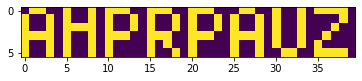

In [129]:
p = Paper(data)
for f in folds:
    f_axis, f_value = f
    p.fold(axis=f_axis, value=f_value)
plt.imshow(p.get_dots())

## Day 12

In [31]:
class CaveNetwork:
    
    def __init__(self, edge_list):
        self.nodes = list(set([x for e in edge_list for x in e]))
        self.edges = dict((n, []) for n in self.nodes)
        for s, t in edge_list:
            if s != "end" and t != "start":
                self.edges[s].append(t)
            if s != "start" and t != "end":
                self.edges[t].append(s)      
        
    def find_all_paths(self):
        t0 = time()
        source = "start"
        target = "end"
        
        paths = [[False, source]]
        extended = True  # part2 edit
        while extended:
            extended = False
            iter_paths = paths.copy()
            prune = []
            print("Elapsed: {:.2f}s. {} incomplete paths.".format(time()-t0, len(paths)))
            for i, p in enumerate(iter_paths):
                if not self.edges[p[-1]] and p[-1] != target:
                    prune.append(p)
                for e in self.edges[p[-1]]:
                    if e.isupper() or (e not in p or not p[0]):  # part2 edit
                        pe = p + [e]
                        if pe not in paths:
                            paths.append(pe)
                            extended = True
                            prune.append(p)
                            if e in p and e.islower():  # part2 edit
                                pe[0] = True
            for p in prune:
                if p in paths:
                    paths.remove(p)
            prune = []
            
        paths = [p for p in paths if p[-1] == target]
        return len(paths), paths

In [32]:
t0 = time()
example1 = [("start", "A"), ("start", "b"), ("A", "c"), ("A", "b"), ("b", "d"), ("A", "end"), ("b", "end")]
cn = CaveNetwork(example1)
np, p = cn.find_all_paths()
np, len(example1), time() - t0

Elapsed: 0.00s. 1 incomplete paths.
Elapsed: 0.00s. 2 incomplete paths.
Elapsed: 0.00s. 6 incomplete paths.
Elapsed: 0.00s. 10 incomplete paths.
Elapsed: 0.00s. 17 incomplete paths.
Elapsed: 0.00s. 26 incomplete paths.
Elapsed: 0.00s. 35 incomplete paths.
Elapsed: 0.00s. 42 incomplete paths.
Elapsed: 0.00s. 42 incomplete paths.


(36, 7, 0.0021598339080810547)

In [33]:
t0 = time()
example2 = [("dc", "end"), ("HN", "start"), ("start", "kj"), ("dc", "start"), ("dc", "HN"), ("LN", "dc"), ("HN", "end"), ("kj", "sa"), ("kj", "HN"), ("kj", "dc")]
cn = CaveNetwork(example2)
np, p = cn.find_all_paths()
np, len(example2), time() - t0

Elapsed: 0.00s. 1 incomplete paths.
Elapsed: 0.00s. 3 incomplete paths.
Elapsed: 0.00s. 10 incomplete paths.
Elapsed: 0.00s. 24 incomplete paths.
Elapsed: 0.00s. 54 incomplete paths.
Elapsed: 0.00s. 100 incomplete paths.
Elapsed: 0.00s. 139 incomplete paths.
Elapsed: 0.00s. 153 incomplete paths.
Elapsed: 0.00s. 153 incomplete paths.


(103, 10, 0.003088235855102539)

In [35]:
t0 = time()
example3 = [("fs", "end"), ("he", "DX"), ("fs", "he"), ("start", "DX"), ("pj", "DX"), ("end", "zg"), ("zg", "sl"), ("zg", "pj"), ("pj", "he"), ("RW", "he"), ("fs", "DX"), ("pj", "RW"), ("zg", "RW"), ("start", "pj"), ("he", "WI"), ("zg", "he"), ("pj", "fs"), ("start", "RW")]
cn = CaveNetwork(example3)
np, p = cn.find_all_paths()
np, len(example3), time() - t0

Elapsed: 0.00s. 1 incomplete paths.
Elapsed: 0.00s. 3 incomplete paths.
Elapsed: 0.00s. 11 incomplete paths.
Elapsed: 0.00s. 52 incomplete paths.
Elapsed: 0.00s. 195 incomplete paths.
Elapsed: 0.02s. 699 incomplete paths.
Elapsed: 0.15s. 2016 incomplete paths.
Elapsed: 0.75s. 4492 incomplete paths.
Elapsed: 2.21s. 7698 incomplete paths.
Elapsed: 4.16s. 10536 incomplete paths.
Elapsed: 5.38s. 12083 incomplete paths.
Elapsed: 5.70s. 12537 incomplete paths.


(3509, 18, 5.7128682136535645)

In [37]:
data = list(get_daily_data(12, sep='-'))
cn = CaveNetwork(data)
np, p = cn.find_all_paths()
np

Elapsed: 0.00s. 1 incomplete paths.
Elapsed: 0.00s. 3 incomplete paths.
Elapsed: 0.00s. 12 incomplete paths.
Elapsed: 0.00s. 50 incomplete paths.
Elapsed: 0.00s. 197 incomplete paths.
Elapsed: 0.02s. 713 incomplete paths.
Elapsed: 0.21s. 2386 incomplete paths.
Elapsed: 2.09s. 7180 incomplete paths.
Elapsed: 13.68s. 18801 incomplete paths.
Elapsed: 79.08s. 43008 incomplete paths.
Elapsed: 314.68s. 82475 incomplete paths.
Elapsed: 929.84s. 139333 incomplete paths.
Elapsed: 2092.71s. 206567 incomplete paths.
Elapsed: 3564.44s. 270249 incomplete paths.
Elapsed: 4708.28s. 314887 incomplete paths.
Elapsed: 5153.93s. 333119 incomplete paths.


99138

## Day 11

In [510]:
def get_adjacent(m, idx):
    adj_idx = []
    for i, j in zip(*idx):
        adj_idx += [(i+1, j), (i-1, j), (i, j+1), (i, j-1), (i+1, j+1), (i-1, j-1), (i+1, j-1), (i-1, j+1)]
    adj_idx = [(i, j) for i, j in adj_idx if i >= 0 and j >= 0 and i < m.shape[0] and j < m.shape[1]]
    return adj_idx
    

def simulate_flashes(m, n_iterations, stop_on_sync=False):
    n_flashed_total = 0
    for r in range(n_iterations):
        flashed = np.zeros(m.shape).astype(bool)
        m += 1
        flash = np.where((m > 9) & ~flashed)
        n_flashed = len(flash[0])
        flashed[flash] = True
        while n_flashed > 0:
            n_flashed_total += n_flashed
            m[flash] = 0
            adj = get_adjacent(m, flash)
            for i, j in adj:
                if not flashed[i, j]:
                    m[i, j] += 1
            flash = np.where((m > 9) & ~flashed)
            n_flashed = len(flash[0])
            flashed[flash] = True
        if stop_on_sync and flashed.all():
            return r + 1, m
    return n_flashed_total, m

In [517]:
small_example = ["11111", "19991", "19191", "19991", "11111"]
small_example = np.array([[int(x) for x in l] for l in small_example])
n, m = simulate_flashes(small_example, 1)
m

array([[3, 4, 5, 4, 3],
       [4, 0, 0, 0, 4],
       [5, 0, 0, 0, 5],
       [4, 0, 0, 0, 4],
       [3, 4, 5, 4, 3]])

In [515]:
example_data = ["5483143223", "2745854711", "5264556173", "6141336146", "6357385478", "4167524645", "2176841721", "6882881134", "4846848554", "5283751526"]
example_data = np.array([[int(x) for x in l] for l in example_data])
example_data
n, m = simulate_flashes(example_data, 100)
n

1656

In [492]:
data = get_daily_data(11)
data = np.array([[int(x) for x in l] for l in data])
n, m = simulate_flashes(data, 100)
n

1705

In [511]:
example_data = ["5483143223", "2745854711", "5264556173", "6141336146", "6357385478", "4167524645", "2176841721", "6882881134", "4846848554", "5283751526"]
example_data = np.array([[int(x) for x in l] for l in example_data])
example_data
n, m = simulate_flashes(example_data, 195, stop_on_sync=True)
n, m

(195,
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [513]:
data = get_daily_data(11)
data = np.array([[int(x) for x in l] for l in data])
i, m = simulate_flashes(data, 1000, stop_on_sync=True)
i

265

## Day 10

In [390]:
example_data = ["[({(<(())[]>[[{[]{<()<>>", "[(()[<>])]({[<{<<[]>>(", "{([(<{}[<>[]}>{[]{[(<()>", "(((({<>}<{<{<>}{[]{[]{}", "[[<[([]))<([[{}[[()]]]", "[{[{({}]{}}([{[{{{}}([]", "{<[[]]>}<{[{[{[]{()[[[]", "[<(<(<(<{}))><([]([]()", "<{([([[(<>()){}]>(<<{{", "<{([{{}}[<[[[<>{}]]]>[]]"]

In [ ]:
# Use a stack to record the chunk opening characters and use a rules dictionary to identify valid end characters
# It is always legal to add another opening character onto the stack.
# If the stack is not empty at the end of the line, then the chunk is incomplete
# If the next character in the string is not a valid closing character for the top of the stack, then the chunk is corrupt

In [382]:
syntax_rules = {"[": "]", "{": "}", "<": ">", "(": ")"}

In [377]:
def check_syntax(chars):
    error_score = {")": 3, "]": 57, "}": 1197, ">": 25137}
    stack = []
    for c in chars:
        if c in syntax_rules.keys():
            stack.insert(0, c)
        elif c in syntax_rules.values():
            if syntax_rules[stack[0]] == c:
                stack.pop(0)
            else:
                return error_score[c]
    if len(stack) > 0:
        pass
    return 0

In [379]:
sum([check_syntax(d) for d in example_data])

26397

In [380]:
sum([check_syntax(d) for d in get_daily_data(10)])

265527

In [394]:
def complete_syntax(chars):   
    completion_score = {")": 1, "]": 2, "}": 3, ">": 4}    
    stack = []
    for c in chars:
        if c in syntax_rules.keys():
            stack.insert(0, c)
        elif c in syntax_rules.values():
            if syntax_rules[stack[0]] == c:
                stack.pop(0)
            else:
                return None
    score = 0
    while len(stack) > 0:
        next_char = syntax_rules[stack.pop(0)]
        score *= 5
        score += completion_score[next_char]
    return score

In [402]:
scores = [complete_syntax(d) for d in example_data]
scores = [s for s in scores if s]
sorted(scores)[int(len(scores)/2)]

288957

In [403]:
scores = [complete_syntax(d) for d in get_daily_data(10)]
scores = [s for s in scores if s]
sorted(scores)[int(len(scores)/2)]

3969823589

## Day 9

In [366]:
def lt_adj(mat, a, b):
    if b[0] < 0 or b[1] < 0:
        return True
    try:
        return mat[a] < mat[b]
    except IndexError:
        return True

class FloorHeight:
    
    def __init__(self, height_data):
        self.height = np.array(height_data, dtype=int)
        self._minima = None
        self._ridge = None
        
    @property
    def risk_levels(self):
        risk_levels = np.zeros(self.height.shape).astype(int)
        risk_levels[self.minima] = self.height[self.minima] + 1
        return risk_levels
    
    @property
    def minima(self):
        if self._minima is None:
            minima = np.zeros(self.height.shape).astype('bool')
            x, y = self.height.shape
            for i in range(x):
                for j in range(y):
                    adj = [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
                    minima[i, j] = all([lt_adj(self.height, (i, j), adj_ij) for adj_ij in adj])
            self._minima = minima
        return self._minima
    
    @property
    def ridge(self):
        if self._ridge is None:
            self._ridge = (self.height == 9)
        return self._ridge
    
    def get_risk(self):
        return self.risk_levels.sum(dtype=int)
    
    def get_height(self, i, j):
        if i < 0 or j < 0:
            return 9
        try:
            return self.height[i, j]
        except IndexError:
            return 9
    
    def find_basins(self):
        basins = []
        for m in zip(*np.where(self.minima)):
            basin = [m]
            i, j = m
            candidates = [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
            candidates = [c for c in candidates if c not in basin]
            candidates = [c for c in candidates if self.get_height(*c) != 9]
            while len(candidates) > 0:
                basin += candidates
                candidates = list(set([c for i, j in basin for c in [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]]))
                candidates = [c for c in candidates if c not in basin]
                candidates = [c for c in candidates if self.get_height(*c) != 9]
            basins.append(sorted(basin))
            basin = []
        basins = sorted([(len(b), b) for b in basins], reverse=True)
        return basins
    
    def score_basins(self):
        basins = self.find_basins()
        return np.product([b[0] for b in basins[:3]])
    
    def plot(self):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
        ax[0].set_title("Sea Floor Height", fontsize=16)
        ax[0].imshow(self.height, cmap='bone')
        ax[1].set_title("Smoke Risk", fontsize=16)
        ax[1].imshow(self.risk_levels, 'gist_heat')
        ax[2].set_title("Basins", fontsize=16)
        ax[2].imshow(self.ridge, 'binary')
        for x in ax:
            x.set_xticklabels([], visible=False)
            x.set_yticklabels([], visible=False)
        sns.despine(bottom=True, left=True)

1134

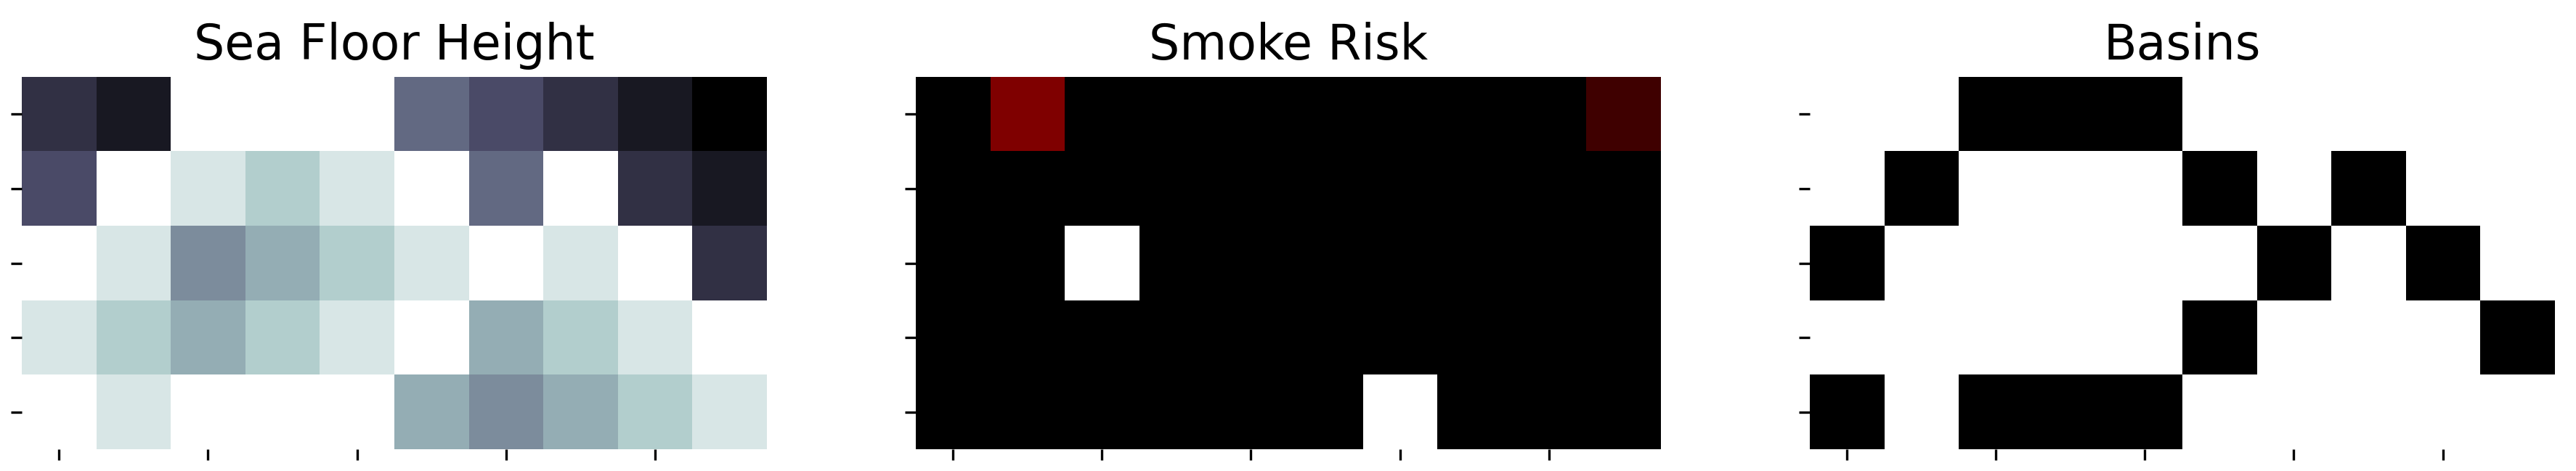

In [367]:
example_data = ["2199943210", "3987894921", "9856789892", "8767896789", "9899965678"]
example_data = [[int(x) for x in l] for l in example_data]
example_data = np.array(example_data)
floor = FloorHeight(example_data)
floor.plot()
floor.get_risk()
floor.score_basins()

964712

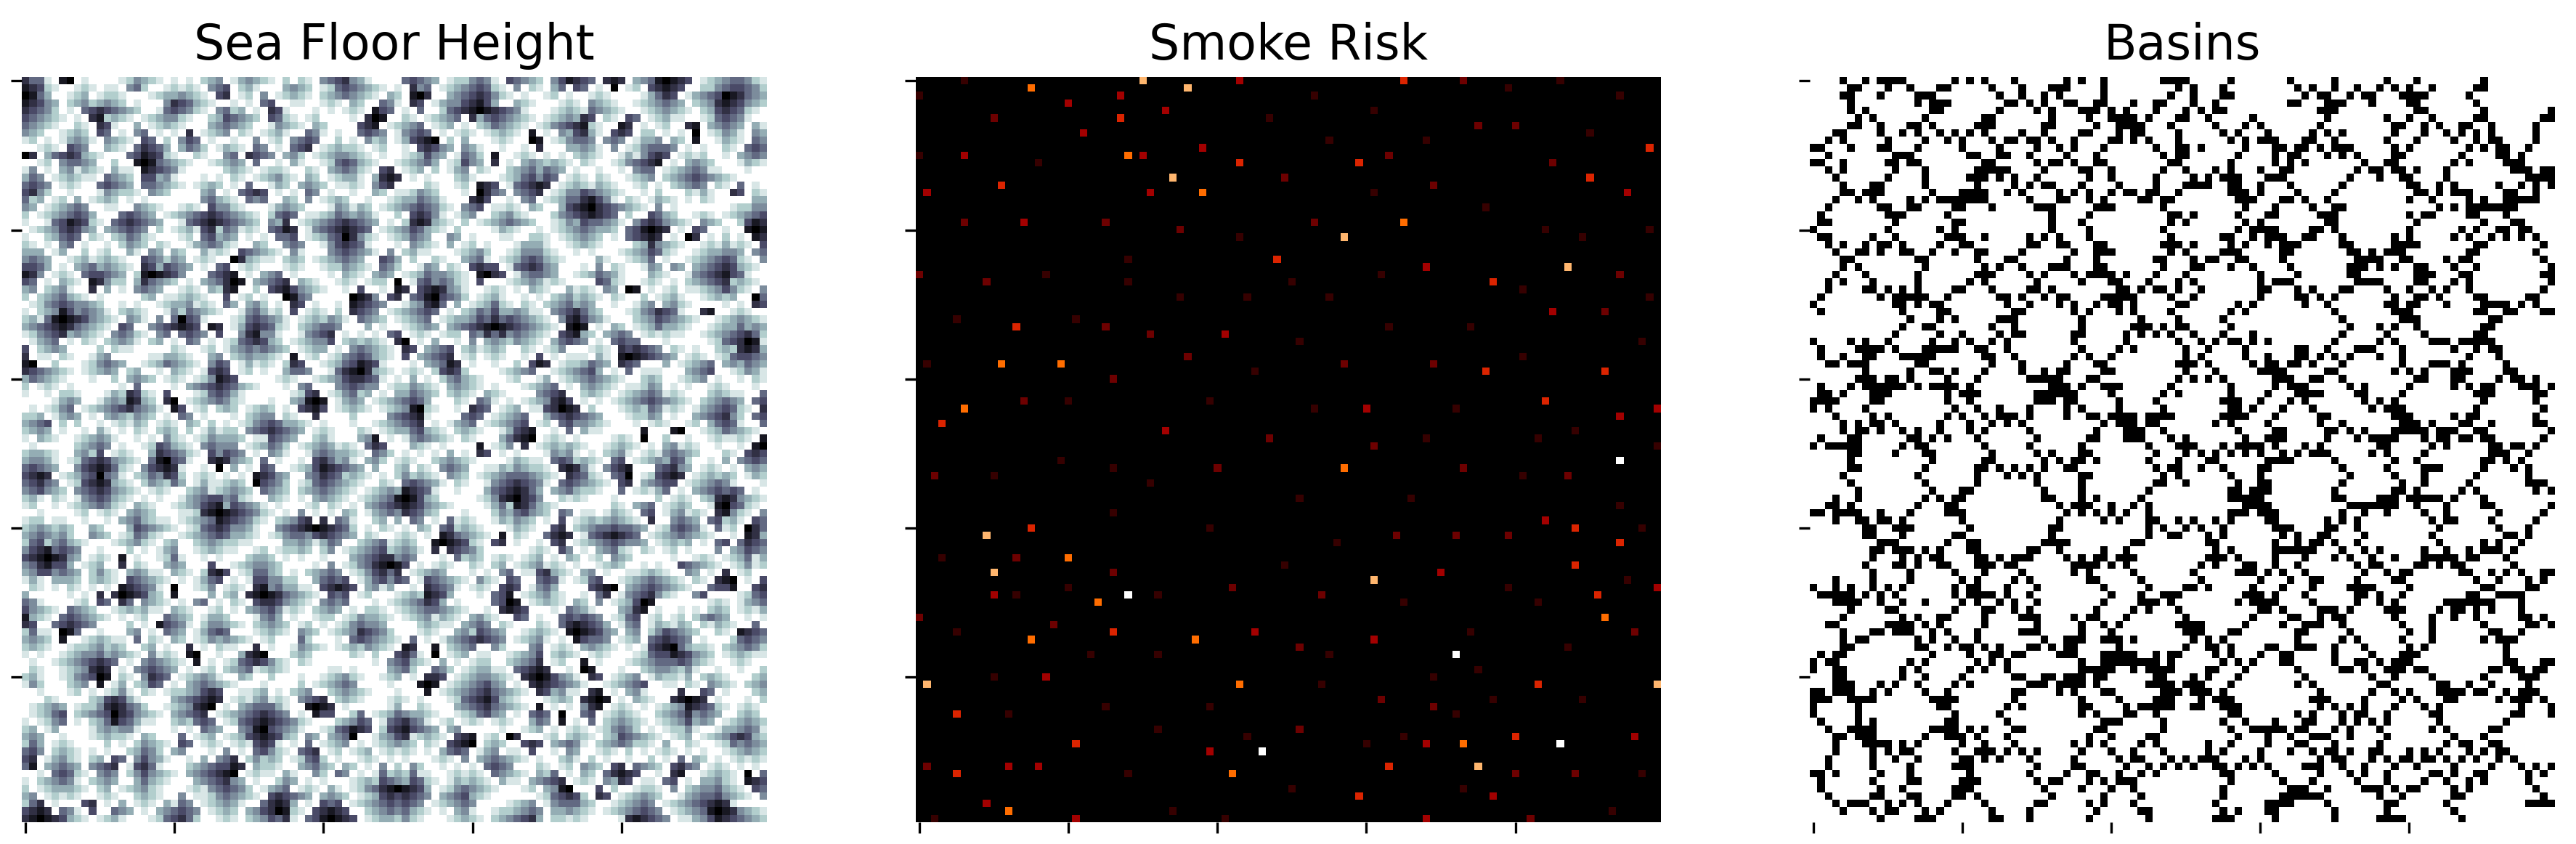

In [368]:
data = [[int(x) for x in l] for l in get_daily_data(9)]
floor = FloorHeight(data)
floor.plot()
floor.get_risk()
floor.score_basins()

## Day 8

In [ ]:
example_data = \
[["be cfbegad cbdgef fgaecd cgeb fdcge agebfd fecdb fabcd edb", "fdgacbe cefdb cefbgd gcbe"],
["edbfga begcd cbg gc gcadebf fbgde acbgfd abcde gfcbed gfec", "fcgedb cgb dgebacf gc"],
["fgaebd cg bdaec gdafb agbcfd gdcbef bgcad gfac gcb cdgabef", "cg cg fdcagb cbg"],
["fbegcd cbd adcefb dageb afcb bc aefdc ecdab fgdeca fcdbega", "efabcd cedba gadfec cb"],
["aecbfdg fbg gf bafeg dbefa fcge gcbea fcaegb dgceab fcbdga", "gecf egdcabf bgf bfgea"],
["fgeab ca afcebg bdacfeg cfaedg gcfdb baec bfadeg bafgc acf", "gebdcfa ecba ca fadegcb"],
["dbcfg fgd bdegcaf fgec aegbdf ecdfab fbedc dacgb gdcebf gf", "cefg dcbef fcge gbcadfe"],
["bdfegc cbegaf gecbf dfcage bdacg ed bedf ced adcbefg gebcd", "ed bcgafe cdgba cbgef"],
["egadfb cdbfeg cegd fecab cgb gbdefca cg fgcdab egfdb bfceg", "gbdfcae bgc cg cgb"],
["gcafb gcf dcaebfg ecagb gf abcdeg gaef cafbge fdbac fegbdc", "fgae cfgab fg bagce"]]

In [ ]:
data = list(get_daily_data(8, sep='|'))

In [ ]:
n_digits = {1: 2, 2:5, 3:5, 4:4, 5:5, 6:6, 7:3, 8:7, 9:6}

In [ ]:
def part1(data):
    answer = 0
    for sequence, output in data:
        output = output.split()
        answer += len([x for x in output if len(x) in (2, 3, 4, 7)])
    return answer

In [ ]:
part1(example_data)

In [ ]:
part1(data)

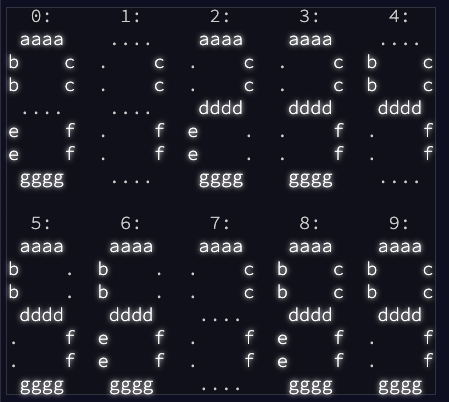

In [ ]:
from itertools import permutations

In [ ]:
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
all_possible_maps = [dict(zip(each_permutation, letters)) for each_permutation in permutations(letters, len(letters))]
digit_sequences = {'abcefg': '0', 'cf': '1', 'acdeg': '2', 'acdfg': '3', 'bcdf': '4',
     'abdfg': '5', 'abdefg': '6', 'acf': '7', 'abcdefg': '8', 'abcdfg': '9'}

In [ ]:
def seq2digit(true_seq):
    return digit_sequences[''.join(sorted(true_seq))]

In [ ]:
def is_valid(sequence):
    # Valid if all sequences are valid digits.
    try:
        _ = [seq2digit(s) for s in sequence]
        return True
    except:
        return False

In [ ]:
def deduce_wiring(sequence):
    i = 0
    for wire_map in all_possible_maps:
        new_seq = [''.join([wire_map[s] for s in seq]) for seq in sequence]
        if is_valid(new_seq):
            break
    
    return wire_map

In [ ]:
def decode(sequence, wire_map):
    digits = []
    for dig_seq in sequence:
        true_seq = ''.join([wire_map[ds] for ds in dig_seq])
        digits.append(seq2digit(true_seq))
    return ''.join(digits)

In [ ]:
def decode_output(sequence, output):
    
    sequence = sequence.split()
    output = output.split()

    wire_map = deduce_wiring(sequence)
    decoded_output = decode(output, wire_map)
            
    return decoded_output

In [ ]:
def decode_sequences(data):
    for sequence, output in data:
        yield decode_output(sequence, output)

In [ ]:
for digit in decode_sequences(example_data):
    print(digit)

In [ ]:
d_sum = 0
for digit in decode_sequences(data):
    d_sum += int(digit)
d_sum

## Day 7

In [ ]:
example_data = [16,1,2,0,4,2,7,1,2,14]

In [ ]:
crab_data = [int(x) for l in get_daily_data(7, sep=',') for x in l]

In [ ]:
def calc_cost(d):
    return int((d * (d + 1)) / 2)

In [ ]:
def get_cost(data, pos):
#     cost = sum([abs(d-pos) for d in data])
    cost = sum([calc_cost(abs(d-pos)) for d in data])
    return cost

In [ ]:
def most_efficient_alignment(data):
    min_pos = min(data)
    max_pos = max(data)
    cost_dict = dict((pos, get_cost(data, pos)) for pos in range(min_pos, max_pos + 1))
    cost_list = [t for t in cost_dict.items()]
    cost_list = sorted(cost_list, key=lambda x: x[1])
    return cost_list.pop(0)

In [ ]:
most_efficient_alignment(example_data)

In [ ]:
most_efficient_alignment(crab_data)

## Day 6

In [ ]:
fisher_timers = [int(x) for x in next(get_daily_data(6)).split(',')]
example_input = [3,4,3,1,2]

In [ ]:
def model_fish(data, n_generations=80):

    new_timer = 8
    reset_timer = 6
    
    fish = dict((i, 0) for i in range(9))
    for f in data:
        fish[f] += 1

    for g in range(n_generations):
        new_fish = fish[0]
        for i in range(8):
            fish[i] = fish[i+1]
        fish[reset_timer] += new_fish
        fish[new_timer] = new_fish
    return sum(fish.values())

In [ ]:
model_fish(example_input, 18)

In [ ]:
model_fish(example_input, 80)

In [ ]:
model_fish(fisher_timers, 80)

In [ ]:
model_fish(example_input, 256)

In [ ]:
model_fish(fisher_timers, 256)

## Day 5

In [ ]:
def parse_coordinates(line):
    row = line.split()
    coords = row[0].split(',') + row[2].split(',')
    coords = [int(c) for c in coords]
    return coords

In [ ]:
class SeaVents:
    
    def __init__(self, lines):
        self.lines = np.array(lines, dtype=int)
        # Note that the vents matrix is transposed
        # The x coordinate is the row and the y coordinate is the column
        self.max_x = max(self.lines[:, 0].max(), self.lines[:, 2].max())
        self.max_y = max(self.lines[:, 1].max(), self.lines[:, 3].max())
        self.vents = np.zeros((self.max_x + 1, self.max_y + 1))
        
    def map_vents(self, diagonals=False):
        n_h = 0
        n_v = 0
        n_d = 0
        for line in self.lines:
            source = [line[0], line[1]]
            target = [line[2], line[3]]
            
            # Record vent at source (NOT target)
            
            
            dx = source[0] - target[0]
            dy = source[1] - target[1]
            
            # Record vents between source and target
            if dx == 0:
                self.vents[source[0], source[1]] += 1
                n_v += 1
                while dy > 0:
                    source[1] -= 1
                    self.vents[source[0], source[1]] += 1
                    dy -= 1
                while dy < 0:
                    source[1] += 1
                    self.vents[source[0], source[1]] += 1
                    dy += 1
                if source != target:
                    raise Exception("{} != {}".format(source, target))
            elif dy == 0:
                self.vents[source[0], source[1]] += 1
                n_h += 1
                while dx > 0:
                    source[0] -= 1
                    self.vents[source[0], source[1]] += 1
                    dx -= 1
                while dx < 0:
                    source[0] += 1
                    self.vents[source[0], source[1]] += 1
                    dx += 1
                if source != target:
                    raise Exception("{} != {}".format(source, target))
            elif diagonals:
                self.vents[source[0], source[1]] += 1
                n_d += 1
                while dx > 0 and dy > 0:
                    source[0] -= 1
                    source[1] -=1
                    self.vents[source[0], source[1]] += 1
                    dx -= 1
                    dy -= 1
                while dx > 0 and dy < 0:
                    source[0] -= 1
                    source[1] +=1
                    self.vents[source[0], source[1]] += 1
                    dx -= 1
                    dy += 1
                while dx < 0 and dy > 0:
                    source[0] += 1
                    source[1] -=1
                    self.vents[source[0], source[1]] += 1
                    dx += 1
                    dy -= 1
                while dx < 0 and dy < 0:
                    source[0] += 1
                    source[1] +=1
                    self.vents[source[0], source[1]] += 1
                    dx += 1
                    dy += 1
                if source != target:
                    raise Exception("{} != {}".format(source, target))
        print("Drew {} horizontal, {} vertical, and {} diagonal lines.".format(n_h, n_v, n_d))
                    
    def n_danger_zones(self):
        return (self.vents > 1).sum()
    
    def plot_vents(self, grid=False):
        if grid:
            sns.set_style("whitegrid")
        else:
            sns.set_style("white")
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        ax[0].imshow(self.vents.T, cmap='Greys')
        ax[1].imshow((self.vents.T > 1), cmap='binary')
        for x in ax:
            x.set_xticks([i + 0.5 for i in range(0, self.max_x)])
            x.set_yticks([i + 0.5 for i in range(0, self.max_y)])
            x.set_xticklabels(range(0, self.max_x), visible=False)
            x.set_yticklabels(range(0, self.max_y), visible=False)
        sns.despine(bottom=True, left=True)

In [ ]:
# Example input
example_data = ["0,9 -> 5,9","8,0 -> 0,8","9,4 -> 3,4","2,2 -> 2,1","7,0 -> 7,4","6,4 -> 2,0","0,9 -> 2,9","3,4 -> 1,4","0,0 -> 8,8","5,5 -> 8,2"]
data = [parse_coordinates(line) for line in example_data]
sv = SeaVents(data)
sv.map_vents()
sv.plot_vents(grid=True)
sv.n_danger_zones()

In [ ]:
data = [parse_coordinates(line) for line in get_daily_data(5)]
sv = SeaVents(data)
sv.map_vents()
sv.plot_vents()
sv.n_danger_zones()

In [ ]:
data = [parse_coordinates(line) for line in get_daily_data(5)]
sv = SeaVents(data)
sv.map_vents(diagonals=True)
sv.plot_vents()
sv.n_danger_zones()

## Day 4

In [ ]:
class BingoBoard:
    
    def __init__(self, values):
        self.values = np.array(values)
        self.marked = np.zeros(self.values.shape).astype(bool)
        
    def mark(self, value):
        idx = np.where(self.values == value)
        self.marked[idx] = True
    
    def bingo(self):
        row_bingo = (self.marked.sum(axis=1) == self.marked.shape[0]).any()
        col_bingo = (self.marked.sum(axis=0) == self.marked.shape[1]).any()
        return row_bingo or col_bingo
        
    def get_unmarked_values(self):
        unmarked = ~self.marked
        return self.values[np.where(unmarked)]

In [ ]:
def init_data():
    data = [line for line in get_daily_data(4)]
    balls = [int(x) for x in data.pop(0).split(',')]
    data.pop(0)  # throw away empty line

    boards = []
    board_values = []
    for line in data:
        if line == "":
            boards.append(BingoBoard(board_values))
            board_values = []
        else:
            row = [int(x) for x in line.split()]
            board_values.append(row)
    return boards, balls

In [ ]:
def play_bingo(boards, balls):
    for bl in balls:
        for bd in boards:
            bd.mark(bl)
            if bd.bingo():
                solution = bd.get_unmarked_values().sum() * bl
                return solution

In [ ]:
boards, balls = init_data()
play_bingo(boards, balls)

In [ ]:
def play_bad_bingo(boards, balls):
    for bl in balls:
        purge = []
        for bd in boards:
            bd.mark(bl)
            if bd.bingo():
                if len(boards) == 1:
                    solution = bd.get_unmarked_values().sum() * bl
                    return solution
                else:
                    purge.append(bd)
        for bd in purge:
            boards.remove(bd)

In [ ]:
boards, balls = init_data()
play_bad_bingo(boards, balls)

In [ ]:
# TODO: Render these on each round of bingo to show how it plays out.
boards, balls = init_data()
fig, ax = plt.subplots(9, 11, figsize=(15, 10))
for i in range(9):
    for j in range(11):
        board = boards[i * 9 + j]
        ax[i][j].imshow(board.marked.astype(int), cmap='binary')
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
sns.despine(bottom=True, left=True)
plt.show()

In [ ]:
raise

## Day 3

In [ ]:
def to_decimal(binary_vector):
    total = 0
    for pos, bit in enumerate(binary_vector[::-1]):
        total += bit * (2 ** pos)
    return total

In [ ]:
import numpy as np
from scipy import stats

data = []
for line in get_daily_data(3):
    data.append([int(x) for x in list(line.strip())])
data = np.array(data)

In [ ]:
gamma_bin = list(stats.mode(data, axis=0)[0][0])
epsilon_bin = [abs(data - 1) for data in gamma_bin]
gamma = to_decimal(gamma_bin)
epsilon = to_decimal(epsilon_bin)
gamma * epsilon

In [ ]:
def most_common(vec):
    n1 = sum(vec)
    n0 = len(vec) - sum(vec)
    if n0 == n1:
        return 1
    elif n0 > n1:
        return 0
    else:
        return 1

In [ ]:
def least_common(vec):
    n1 = sum(vec)
    n0 = len(vec) - sum(vec)
    if n0 == n1:
        return 0
    elif n0 > n1:
        return 1
    else:
        return 0

In [ ]:
def find_og_rating(data):
    for col in range(data.shape[1]):
        x = data[:, col]
        mode = most_common(x)
        data = data[x == mode, :]
        if data.shape[0] == 1:
            break
    assert(data.shape[0] == 1)
    return to_decimal(data[0, :])

In [ ]:
def find_co2_rating(data):
    for col in range(data.shape[1]):
        x = data[:, col]
        antimode = least_common(x)
        data = data[x == antimode, :]
        if data.shape[0] == 1:
            break
    assert(data.shape[0] == 1)
    return to_decimal(data[0, :])

In [ ]:
og = find_og_rating(data)
og

In [ ]:
co2 = find_co2_rating(data)
co2

In [ ]:
og * co2

In [ ]:
# 7105014 is too high

## Day 2

In [ ]:
horizontal_loc = 0
depth_loc = 0
for direction, value in get_daily_data(2, ' '):
    value = int(value)
    if direction == "forward":
        horizontal_loc += value
    elif direction == "down":
        depth_loc += value
    elif direction == "up":
        depth_loc -= value
horizontal_loc * depth_loc

In [ ]:
horizontal_loc = 0
depth_loc = 0
aim = 0
for direction, value in get_daily_data(2, ' '):
    value = int(value)
    if direction == "forward":
        horizontal_loc += value
        depth_loc += value * aim
    elif direction == "down":
        aim += value
    elif direction == "up":
        aim -= value
horizontal_loc * depth_loc

## Day 1

In [ ]:
n_increases = 0
prev_x = 9e32
for value in get_daily_data(1):
        x = int(value)
        if x > prev_x:
            n_increases += 1
        prev_x = x
n_increases

In [ ]:
n_increases = 0
window = []
prev_sum = None
for value in get_daily_data(1):
    x = int(value)
    if len(window) < 3:
        window.append(x)
    if prev_sum is None:
        prev_sum = sum(window)
    if len(window) == 3:
        window.pop(0)
        window.append(x)
        new_sum = sum(window)
        if new_sum > prev_sum:
            n_increases += 1
        prev_sum = new_sum
n_increases